In [1]:
import os
import numpy as np # type: ignore
import pandas as pd # type: ignore
import tensorflow as tf # type: ignore
import json
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.metrics import roc_curve, auc # type: ignore
from sklearn.decomposition import PCA
from visualizations import *

/Users/bwelsh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = []
with open('../json/reviews_Kindle_Store_5.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))


df = pd.DataFrame(data)
df = df[['reviewerID', 'asin', 'overall', 'unixReviewTime']]
df.dropna(inplace=True)

In [3]:
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
item_enc = LabelEncoder()

clean_df = pd.DataFrame()

df['user'] = user_enc.fit_transform(df['reviewerID'])
df['item'] = item_enc.fit_transform(df['asin'])
df['rating'] = df['overall']


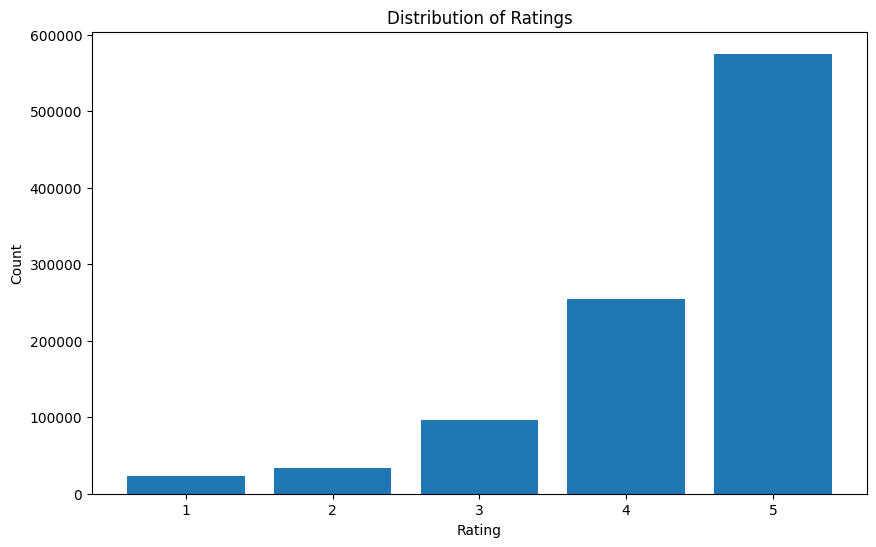

In [4]:
plot_rating_distribution(df)

In [5]:
clean_df = df[['user', 'item', 'rating']]
clean_df

,user,item,rating
0,7773,0,5.0
1,61894,0,4.0
2,53977,0,4.0
3,8128,0,5.0
4,50527,0,4.0
...,...,...,...
982614,35142,61933,5.0
982615,4097,61933,5.0
982616,18464,61933,5.0
982617,5981,61933,5.0


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        
        self.users = torch.tensor(df['user'].values, dtype=torch.long)
        self.items = torch.tensor(df['item'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float).view(-1, 1)
        # Normalize ratings for BCE loss
        self.ratings = (self.ratings - 1) / 4.0  # Assuming ratings are 1-5
        
    def __len__(self):
        return len(self.users)
        
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [72]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dimension=8, mlp_layers=[16,8], dropout=0.2):
        """ 
        num_users: number of users
        num_items: number of items
        embedding_dimension: dimension of the embeddings for the matrix factorization
        mlp_layers: sizes of hidden mulit-layer-perceptron
        dropout: dropout probability for regularization
        """
        super(NCF, self).__init__()

        # Dropout to avoid overfitting
        self.dropout = nn.Dropout(dropout)

        #Matrix factorization embeddings
        self.user_embeddings_mf = nn.Embedding(num_users, embedding_dimension)
        self.item_embeddings_mf = nn.Embedding(num_items, embedding_dimension)

        #multi-layer perceptron embeddings
        self.user_embeddings_mlp = nn.Embedding(num_users, embedding_dimension)
        self.item_embeddings_mlp = nn.Embedding(num_items, embedding_dimension)

        #MLP layers with batch normalization
        mlp_modules = []
        input_size = embedding_dimension * 2
        for layer_size in mlp_layers:
            mlp_modules.append(nn.Linear(input_size, layer_size))
            mlp_modules.append(nn.BatchNorm1d(layer_size))
            mlp_modules.append(nn.ReLU())
            mlp_modules.append(nn.Dropout(p=dropout))
            input_size = layer_size
        
        self.mlp = nn.Sequential(*mlp_modules)

        predict_size = embedding_dimension + mlp_layers[-1]
        
        # Final prediction layer -> output single score
        self.final_layer = nn.Sequential(
            nn.Linear(predict_size, 1),
            nn.Sigmoid()
        )

    def forward(self, user_ids, item_ids):
        """
        user_ids: [batch_size]
        item_ids: [batch_size]
        returns: predicted score [batch_size, 1]
        """
        # GMF part
        user_gmf = self.dropout(self.user_embeddings_mf(user_ids))
        item_gmf = self.dropout(self.item_embeddings_mf(item_ids))
        gmf_output = user_gmf * item_gmf
        
        # MLP part
        user_mlp = self.dropout(self.user_embeddings_mlp(user_ids))
        item_mlp = self.dropout(self.item_embeddings_mlp(item_ids))
        mlp_input = torch.cat((user_mlp, item_mlp), dim=1)
        mlp_output = self.mlp(mlp_input)

        # Concatenate GMF & MLP
        concat = torch.cat((gmf_output, mlp_output), dim=1)
        
        # Final layer
        preds = self.final_layer(concat)
        return preds

In [9]:
def data_split(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    df = df.sort_values(by=["user", "item"]) 
    unique_users = df['user'].unique()

    #for this dataset, we will split the data into train/val and test
    #we will use 80% of users for train/val and include some of their interactions in test
    #the remaining 20% of users will only appear in test (cold-start scenario)
    np.random.seed(42)  # For reproducibility
    train_val_users = np.random.choice(
        unique_users, 
        size=int(0.8 * len(unique_users)), 
        replace=False
    )
    cold_start_users = np.array(list(set(unique_users) - set(train_val_users)))
    
    #create dataframes for each user group
    train_val_df = df[df['user'].isin(train_val_users)]
    cold_start_df = df[df['user'].isin(cold_start_users)]
    
    #shuffle the interactions for train/val so that the data is more random
    train_val_indices = train_val_df.index.values
    np.random.shuffle(train_val_indices)
    
    train_size = int(len(train_val_indices) * (train_ratio / (train_ratio + val_ratio)))
    
    train_indices = train_val_indices[:train_size]
    val_indices = train_val_indices[train_size:]
    
    train_df = df.loc[train_indices]
    val_df = df.loc[val_indices]
    
    # For test set, combine some interactions from train/val users and all cold-start users
    # Sample some interactions from train/val users for the test set
    train_val_test_size = int(len(train_val_df) * (test_ratio / (train_ratio + val_ratio + test_ratio)))
    train_val_test_indices = np.random.choice(train_val_indices, size=train_val_test_size, replace=False)
    
    # Combine with cold-start users
    test_df = pd.concat([df.loc[train_val_test_indices], cold_start_df])
    
    print(f"Training set: {len(train_df)} interactions, {train_df['user'].nunique()} users")
    print(f"Validation set: {len(val_df)} interactions, {val_df['user'].nunique()} users")
    print(f"Test set: {len(test_df)} interactions, {test_df['user'].nunique()} users")
    print(f"Test set includes {cold_start_df['user'].nunique()} new users not seen during training")
    
    return train_df, val_df, test_df, cold_start_df
    


In [10]:
#old training loop
# train, test = leave_one_out_split(clean_df)

# train_dataset = RatingDataset(train)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# test_dataset = RatingDataset(test)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# # Sample hyperparameters
# num_users = clean_df['user'].max() + 1  # +1 because 0-indexed
# num_items = clean_df['item'].max() + 1  # +1 because 0-indexed
# embedding_dimension = 8

# model = NCF(num_users, num_items, embedding_dimension=embedding_dimension, mlp_layers=[16, 8])
# model.train()  # set to training mode

# criterion = nn.BCELoss()  #This will classify the reviews as either positive or negative
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) #L2 regularization to prevent overfitting

# """ Plotting data structures """
# # Plotting loss over time
# running_loss = []

# # Training loop (will overfit)
# epochs = 20
# for epoch in range(epochs):
#     total_loss = 0.0
#     for batch_users, batch_items, batch_ratings in train_loader:
#         optimizer.zero_grad()
#         predictions = model(batch_users, batch_items)
#         loss = criterion(predictions, batch_ratings)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item() * batch_users.size(0)  # Weighted by batch size

#     avg_loss = total_loss / len(train_dataset)

#     # append the loss to the running_loss list
#     running_loss.append(avg_loss)
    
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

In [11]:
train, val, test, cold_start_df = data_split(clean_df)

train_dataset = RatingDataset(train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = RatingDataset(val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = RatingDataset(test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

Training set: 646230 interactions, 54575 users
Validation set: 138478 interactions, 43549 users
Test set: 315617 interactions, 54291 users
Test set includes 13645 new users not seen during training


In [74]:
num_users = clean_df['user'].max() + 1  
num_items = clean_df['item'].max() + 1  
embedding_dimension = 8

model = NCF(num_users, num_items, embedding_dimension=embedding_dimension, mlp_layers=[16, 8])

# BCE loss will classify the reviews as either positive or negative
criterion = nn.BCELoss()
# the optimizer will update the model parameters (parameters found online, will be tweaked)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
# Will reduce learning rate if validation loss doesn't improve
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=4, verbose=True)
    
# Early stopping if validation loss doesn't improve for 3 epochs
best_val_loss = float('inf')
patience = 3
patience_counter = 0
    
running_losses = []
val_losses = []

num_epochs=50

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch_users, batch_items, batch_ratings in train_loader:
            
        optimizer.zero_grad()
        predictions = model(batch_users, batch_items)
        loss = criterion(predictions, batch_ratings)
        loss.backward()
            
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
        optimizer.step()
        train_loss += loss.item() * batch_users.size(0)
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    running_losses.append(avg_train_loss)
        
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_users, batch_items, batch_ratings in val_loader:
                
            predictions = model(batch_users, batch_items)
            loss = criterion(predictions, batch_ratings)
            val_loss += loss.item() * batch_users.size(0)
        
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
        
    # Learning rate scheduling 
    scheduler.step(avg_val_loss)
        
   # Early stopping check if validation loss doesn't improve for 3 epochs
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best version of the model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

/Users/bwelsh/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Loss: 0.4452, Val Loss: 0.3861
Epoch 2/50
Train Loss: 0.4118, Val Loss: 0.3815
Epoch 3/50
Train Loss: 0.4099, Val Loss: 0.3804
Epoch 4/50
Train Loss: 0.4096, Val Loss: 0.3808
Epoch 5/50
Train Loss: 0.4093, Val Loss: 0.3793
Epoch 6/50
Train Loss: 0.4090, Val Loss: 0.3799
Epoch 7/50
Train Loss: 0.4089, Val Loss: 0.3788
Epoch 8/50
Train Loss: 0.4091, Val Loss: 0.3804
Epoch 9/50
Train Loss: 0.4090, Val Loss: 0.3801
Early stopping triggered at epoch 10


/var/folders/xh/_tzk65hj6pn1zkd30431w60h0000gn/T/ipykernel_59261/1042755466.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

<All keys matched successfully>

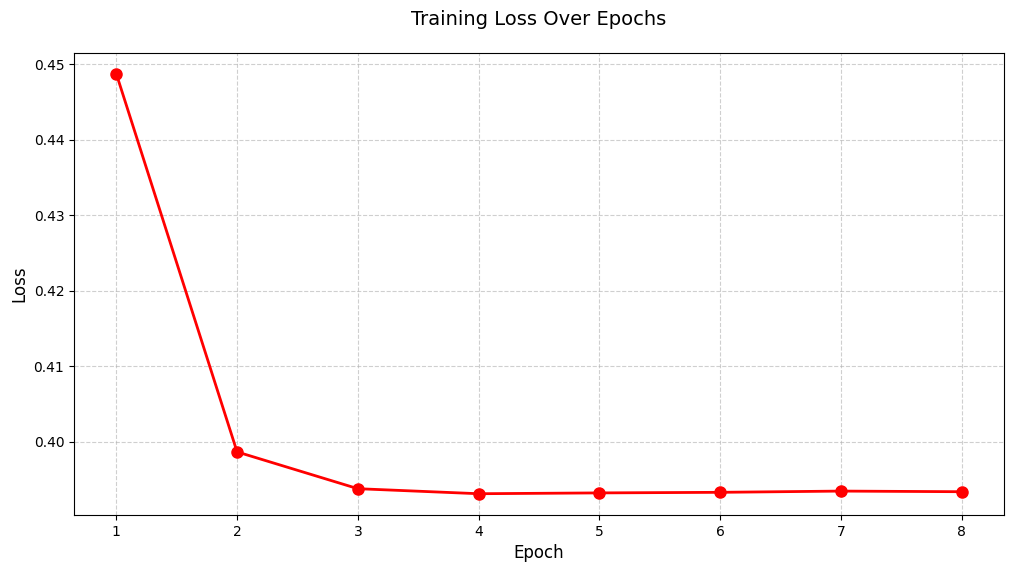

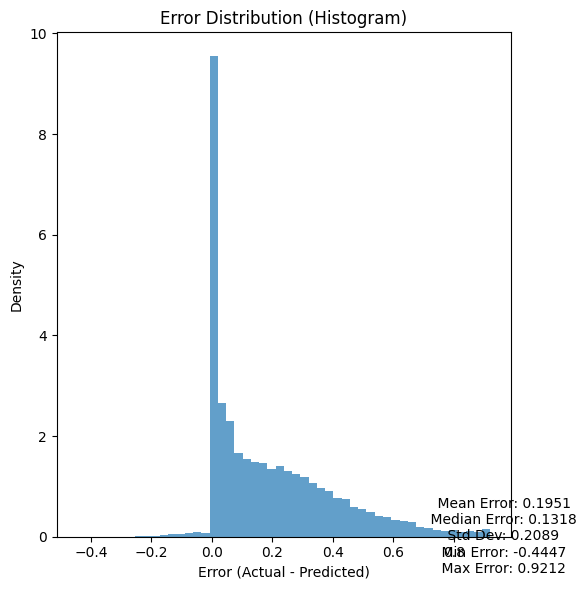

/Users/bwelsh/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/bwelsh/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


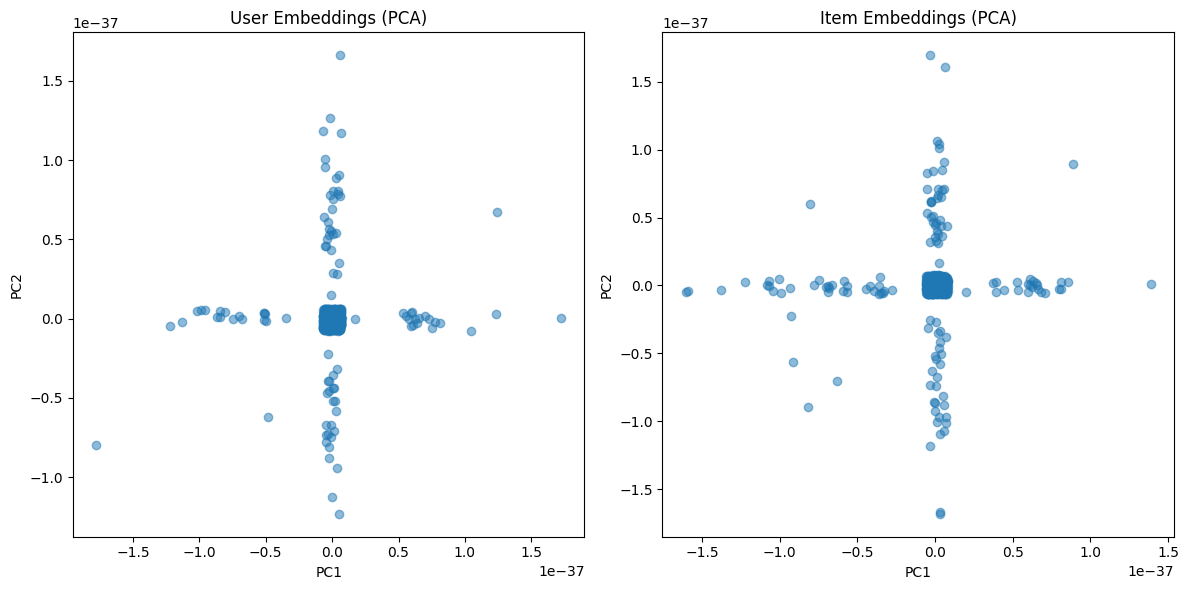

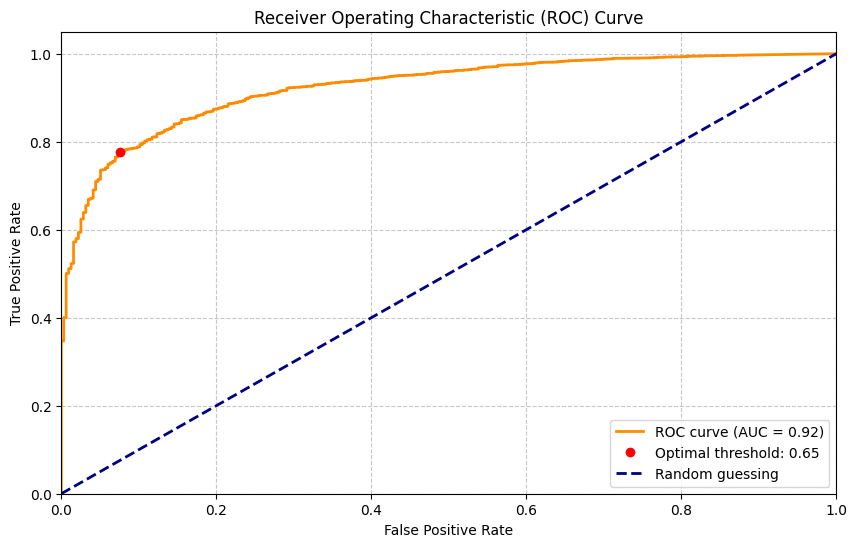

In [62]:
#use graph functions in visualizations.py
plot_training_history(running_losses, "training_history.png")

plot_error_distribution(model, test_loader, save_path="error_distribution.png")

plot_embeddings(model, clean_df, save_path="embeddings.png")

plot_roc_curve(model, test_loader, criterion, save_path="roc_curve.png")

In [ ]:

model.eval()
with torch.no_grad():
    # Get cold start users
    cold_start_users = cold_start_df['user'].unique()
    
    # Initialize separate loss trackers
    cold_start_loss = 0.0
    non_cold_start_loss = 0.0
    cold_start_count = 0
    non_cold_start_count = 0
    test_loss = 0.0
    
    # Evaluate each batch
    for batch_users, batch_items, batch_ratings in test_loader:
        
        predictions = model(batch_users, batch_items)
        test_loss += criterion(predictions, batch_ratings).item() * batch_users.size(0)
        
        # Separate cold start and non-cold start users in the batch
        for i in range(len(batch_users)):
            user_id = batch_users[i].item()
            if user_id in cold_start_users:
                cold_start_loss += criterion(predictions[i:i+1], batch_ratings[i:i+1]).item()
                cold_start_count += 1
            else:
                non_cold_start_loss += criterion(predictions[i:i+1], batch_ratings[i:i+1]).item()
                non_cold_start_count += 1
    
    # Calculate average losses
    avg_cold_start_loss = cold_start_loss / cold_start_count if cold_start_count > 0 else 0
    avg_non_cold_start_loss = non_cold_start_loss / non_cold_start_count if non_cold_start_count > 0 else 0
    avg_test_loss = test_loss / len(test_dataset)
    
    print(f"Cold Start Users Test Loss: {avg_cold_start_loss:.4f}")
    print(f"Non-Cold Start Users Test Loss: {avg_non_cold_start_loss:.4f}")
    print(f"Cold Start Count: {cold_start_count}, Non-Cold Start Count: {non_cold_start_count}")
    print(f"Test Loss: {avg_test_loss:.4f}")


Cold Start Users Test Loss: 0.4365
Non-Cold Start Users Test Loss: 0.3741
Cold Start Count: 197911, Non-Cold Start Count: 117706
Test Loss: 0.4132


In [70]:
def top_k_recommendations(model, user_id, train, k=10):
    """
    Get top-k item recommendations for a given user.
    
    Args:
        model: Trained NCF model
        user_id: ID of the user to get recommendations for
        k: Number of recommendations to return
    
    Returns:
        tuple: (top_k_items, top_k_scores) where:
            top_k_items: List of k recommended item IDs
            top_k_scores: List of k predicted scores for the recommended items
    """
    
    # If item_ids not provided, use all items in the model

    item_ids = torch.arange(model.item_embeddings_mf.num_embeddings)
    
    # Create user tensor (repeat user_id for each item)
    user_tensor = torch.full((len(item_ids),), user_id)
    
    # Get predictions for all items
    with torch.no_grad():
        model.eval()
        predictions = model(user_tensor, item_ids)
        predictions = predictions.squeeze()
    
    
    
    # Get top k items and their scores
    top_k_scores, top_k_indices = torch.topk(predictions, k)
    
    return item_ids[top_k_indices].cpu().numpy(), top_k_scores.cpu().numpy()   

Here and below will be for the evaluation of the top K recommendations

In [20]:
def leave_one_out_split(df):
    df = df.sort_values(by=["user", "item"])

    test_rows = []
    train_rows = []
    # Leave one review with the highest rating per user for test set
    # Only include users who have at least one rating >= 3
    for user, group in df.groupby("user"):
        high_ratings = group[group['rating'] >= 3]
        if high_ratings.empty:
            continue
            
        # Find the highest rated item for this user
        max_rating_idx = group['rating'].idxmax()
        test_rows.append(group.loc[max_rating_idx])
        
        # Add all other reviews to training
        train_group = group.drop(max_rating_idx)
        if not train_group.empty:
            train_rows.append(train_group)

    test_df = pd.DataFrame(test_rows)
    train_df = pd.concat(train_rows)

    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [21]:
train, test = leave_one_out_split(clean_df)
train_dataset = RatingDataset(train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = RatingDataset(test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [67]:
model2 = NCF(num_users, num_items, embedding_dimension=8, mlp_layers=[16, 8])
model2.train()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

running_losses = []

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0.0
    for batch_users, batch_items, batch_ratings in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_users, batch_items)
        loss = criterion(predictions, batch_ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_users.size(0)

    avg_loss = total_loss / len(train_dataset)
    running_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.2971
Epoch 2/10, Loss: 0.2949
Epoch 3/10, Loss: 0.2932
Epoch 4/10, Loss: 0.2919
Epoch 5/10, Loss: 0.2908
Epoch 6/10, Loss: 0.2898
Epoch 7/10, Loss: 0.2890
Epoch 8/10, Loss: 0.2881
Epoch 9/10, Loss: 0.2873
Epoch 10/10, Loss: 0.2866


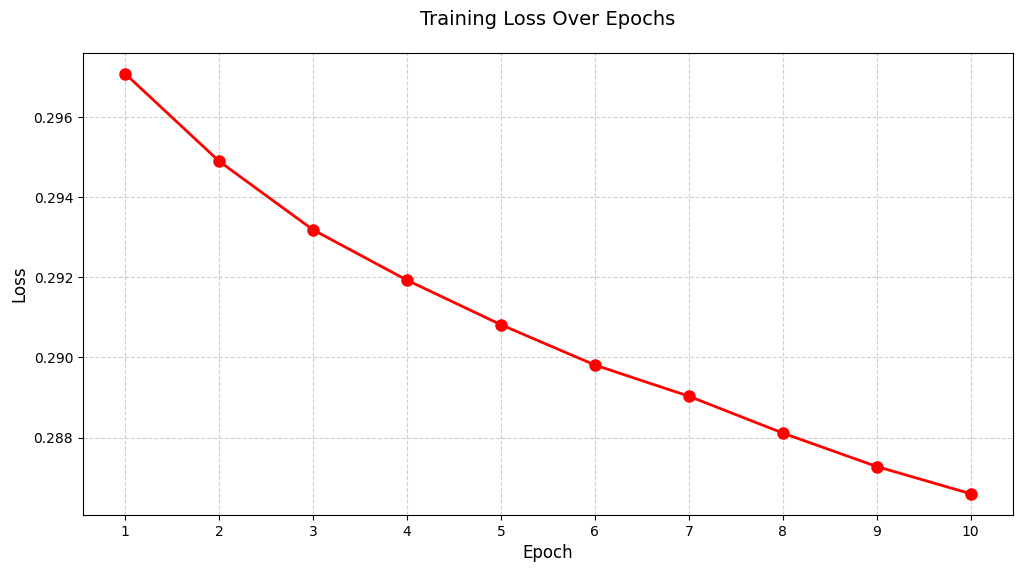

In [73]:
plot_training_history(running_losses, "training_history.png")

In [71]:
# Evaluation function to check if test item is in top-10 recommendations
def evaluate_top_10(model, test_loader, train):
    model.eval()  # Set model to evaluation mode
    hits = 0
    total = 0
    
    with torch.no_grad():
            for batch_users, batch_items, batch_ratings in test_loader:
                # Process each user-item pair in the batch
                for user, item, rating in zip(batch_users, batch_items, batch_ratings):
                    user_id = user.item()
                    item_id = item.item()
                    # Get top 10 recommendations
                    recommended_items = top_k_recommendations(model, user_id, train)[0].tolist()
                    # Check if the test item is in the top 10 recommendations
                    if item_id in recommended_items:
                        hits += 1
                        print(f"Hits: {hits}, Total: {total}")
                    total += 1

                    if total%1000 == 0:
                        print(f"Hits: {hits}, Total: {total}")
                    
                    if total >= 68000:
                        break
                
                if total >= 68000:
                    break
    # Calculate hit ratio
    hit_ratio = hits / total if total > 0 else 0
    print(f"Hit Ratio @ 10: {hit_ratio:.4f}")
    return hit_ratio

evaluate_top_10(model2, test_loader, train)

Hits: 0, Total: 1000
Hits: 0, Total: 2000
Hits: 1, Total: 2862
Hits: 1, Total: 3000
Hits: 2, Total: 3058
Hits: 2, Total: 4000
Hits: 2, Total: 5000
Hits: 2, Total: 6000
Hits: 2, Total: 7000
Hits: 2, Total: 8000
Hits: 2, Total: 9000
Hits: 2, Total: 10000
Hits: 2, Total: 11000
Hits: 3, Total: 11655
Hits: 3, Total: 12000
Hits: 3, Total: 13000
Hits: 3, Total: 14000
Hits: 4, Total: 14103
Hits: 4, Total: 15000
Hits: 4, Total: 16000
Hits: 4, Total: 17000
Hits: 4, Total: 18000
Hits: 5, Total: 18889
Hits: 5, Total: 19000
Hits: 5, Total: 20000
Hits: 5, Total: 21000
Hits: 5, Total: 22000
Hits: 5, Total: 23000
Hits: 5, Total: 24000
Hits: 5, Total: 25000
Hits: 5, Total: 26000
Hits: 5, Total: 27000
Hits: 5, Total: 28000
Hits: 6, Total: 28158
Hits: 6, Total: 29000
Hits: 6, Total: 30000
Hits: 6, Total: 31000
Hits: 7, Total: 31275
Hits: 7, Total: 32000
Hits: 7, Total: 33000
Hits: 7, Total: 34000
Hits: 7, Total: 35000
Hits: 7, Total: 36000
Hits: 7, Total: 37000
Hits: 7, Total: 38000
Hits: 8, Total: 38068

0.0001911764705882353